# 05 Final Pipeline - Reproducible Geospatial ETL

**Objective**: Complete, reproducible pipeline for Madrid Airbnb data:
1. Load raw CSV/GeoJSON files
2. Clean calendar, listings, reviews
3. Perform spatial join (listings → neighbourhoods)
4. Aggregate metrics per neighbourhood (price, availability, density)
5. Export processed datasets + webmap-ready GeoJSON

**Key Features**:
- ✅ Zero hardcoded paths (pathlib + PROJECT_ROOT)
- ✅ Quality checks at every step (assertions + logging)
- ✅ Proper CRS handling (EPSG:4326 for web, metric for area/density)
- ✅ Reusable functions from `src/` package
- ✅ Robust fallback for missing columns

**Output Files**:
- `data/processed/calendar_clean.parquet`
- `data/processed/listings_clean.parquet`
- `data/processed/reviews_listing_features.parquet`
- `data/processed/neighbourhoods_enriched.geojson` ← webmap ready
- And more...

In [1]:
# ============================================================================
# SETUP & CONFIGURATION
# ============================================================================

import sys
from pathlib import Path

# Set PROJECT_ROOT
cwd = Path.cwd()
if (cwd / 'src').exists() and (cwd / 'data').exists():
    PROJECT_ROOT = cwd
elif (cwd.parent / 'src').exists() and (cwd.parent / 'data').exists():
    PROJECT_ROOT = cwd.parent
else:
    PROJECT_ROOT = cwd.parent

sys.path.insert(0, str(PROJECT_ROOT))

# Import base libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Import src modules directly (not via __init__)
from src import config
from src.config import PROJECT_ROOT, INPUT_FILES, OUTPUT_FILES, CRS_WEB, CRS_METRIC
from src import io, cleaning, reviews, spatial, qc

# Configure
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n" + "=" * 80)
print("✓ SETUP COMPLETE")
print("=" * 80)
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print("=" * 80)


✓ SETUP COMPLETE
PROJECT_ROOT: /Users/virginiadimauro/Desktop/UNITN/Secondo Anno/Geospatial Analysis/geospatial-project


In [2]:

# ============================================================================
# VERIFICATION CELL: Price Parser Unit Test (MANDATORY)
# ============================================================================

import importlib
import inspect

importlib.reload(cleaning)
print("MODULE PATH:", cleaning.__file__)

# Test unitario parser (deve passare)
test = pd.Series(["$157.00", "$1,234.56", " $79.00 "])
out = cleaning.parse_price_series(test)
print("\n✓ parse_price_series test output:", out.tolist())

try:
    assert out.notna().sum() == 3, f"parse_price_series is broken (should parse $ prices). Got {out.notna().sum()} non-null"
    print("✓ TEST PASSED: All $ prices parsed successfully")
except AssertionError as e:
    raise AssertionError(f"CRITICAL: {e}")

print("=" * 80)

MODULE PATH: /Users/virginiadimauro/Desktop/UNITN/Secondo Anno/Geospatial Analysis/geospatial-project/src/cleaning.py

✓ parse_price_series test output: [157.0, 1234.56, 79.0]
✓ TEST PASSED: All $ prices parsed successfully


In [3]:
print("\n" + "=" * 80)
print("VERIFICATION: Checking imported modules")
print("=" * 80)

# Verify cleaning module is from the correct file
import inspect
print(f"\n✓ cleaning module loaded from: {cleaning.__file__}")

# Show first 40 lines of clean_listings()
print(f"\n📄 clean_listings() first 40 lines:")
print("-" * 80)
source_clean_listings = inspect.getsource(cleaning.clean_listings)
lines_listings = source_clean_listings.split('\n')[:40]
for i, line in enumerate(lines_listings, 1):
    print(f"{i:3d} | {line}")

print(f"\n📄 clean_calendar() first 40 lines:")
print("-" * 80)
source_clean_calendar = inspect.getsource(cleaning.clean_calendar)
lines_calendar = source_clean_calendar.split('\n')[:40]
for i, line in enumerate(lines_calendar, 1):
    print(f"{i:3d} | {line}")

print("=" * 80)


VERIFICATION: Checking imported modules

✓ cleaning module loaded from: /Users/virginiadimauro/Desktop/UNITN/Secondo Anno/Geospatial Analysis/geospatial-project/src/cleaning.py

📄 clean_listings() first 40 lines:
--------------------------------------------------------------------------------
  1 | def clean_listings(df_listings):
  2 |     """
  3 |     Clean listings data: normalize columns, fix geo columns, handle prices.
  4 |     
  5 |     Args:
  6 |         df_listings: Raw listings DataFrame
  7 |     
  8 |     Returns:
  9 |         Cleaned DataFrame and log info
 10 |     """
 11 |     log = []
 12 |     df_clean = df_listings.copy()
 13 |     
 14 |     # 1. Normalize column names
 15 |     df_clean.columns = [col.lower().replace(' ', '_') for col in df_clean.columns]
 16 |     log.append(f"✓ Column names normalized")
 17 |     
 18 |     # 2. Find and rename ID column
 19 |     id_col = None
 20 |     for col in df_clean.columns:
 21 |         if col == 'id' or (col.ends

## Step 1: Load Raw Data

In [4]:
print("\n" + "=" * 80)
print("STEP 1: LOADING RAW DATA")
print("=" * 80)

# Load required files
try:
    df_calendar = io.load_csv(config.INPUT_FILES['calendar'])
    print(f"\n✓ Loaded calendar.csv: {df_calendar.shape}")
    print(f"  Columns: {df_calendar.columns.tolist()[:8]}...")
except Exception as e:
    raise FileNotFoundError(f"Failed to load calendar.csv: {e}")

try:
    df_listings = io.load_csv(config.INPUT_FILES['listings'])
    print(f"✓ Loaded listings.csv: {df_listings.shape}")
    print(f"  Columns: {df_listings.columns.tolist()[:8]}...")
except Exception as e:
    raise FileNotFoundError(f"Failed to load listings.csv: {e}")

try:
    df_reviews = io.load_csv(config.INPUT_FILES['reviews'])
    print(f"✓ Loaded reviews.csv: {df_reviews.shape}")
    print(f"  Columns: {df_reviews.columns.tolist()}")
except Exception as e:
    raise FileNotFoundError(f"Failed to load reviews.csv: {e}")

try:
    gdf_neighbourhoods = io.load_geojson(config.INPUT_FILES['neighbourhoods'])
    print(f"✓ Loaded neighbourhoods.geojson: {gdf_neighbourhoods.shape}")
    print(f"  CRS: {gdf_neighbourhoods.crs}")
except Exception as e:
    raise FileNotFoundError(f"Failed to load neighbourhoods.geojson: {e}")

# Load optional files
df_listings_summary = None
try:
    df_listings_summary = io.load_csv(config.INPUT_FILES['listings_summary'])
    print(f"✓ Loaded listings_summary.csv (optional): {df_listings_summary.shape}")
except FileNotFoundError:
    print(f"⚠️  listings_summary.csv not found (optional)")

df_reviews_summary = None
try:
    df_reviews_summary = io.load_csv(config.INPUT_FILES['reviews_summary'])
    print(f"✓ Loaded reviews_summary.csv (optional): {df_reviews_summary.shape}")
except FileNotFoundError:
    print(f"⚠️  reviews_summary.csv not found (optional)")

print("\n✓ All required files loaded successfully")
print("=" * 80)


STEP 1: LOADING RAW DATA



✓ Loaded calendar.csv: (9125007, 7)
  Columns: ['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']...


✓ Loaded listings.csv: (25000, 79)
  Columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview']...


✓ Loaded reviews.csv: (1275992, 6)
  Columns: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']
✓ Loaded neighbourhoods.geojson: (128, 3)
  CRS: EPSG:4326


✓ Loaded listings_summary.csv (optional): (25000, 18)


✓ Loaded reviews_summary.csv (optional): (1275992, 2)

✓ All required files loaded successfully


## Step 2: Clean Calendar Data

In [5]:
print("\n" + "=" * 80)
print("STEP 2: CLEANING CALENDAR DATA")
print("=" * 80)

print(f"\nBefore cleaning:")
print(f"  Shape: {df_calendar.shape}")
print(f"  Columns: {df_calendar.columns.tolist()}")
print(f"  Dtypes:\n{df_calendar.dtypes}")

# Clean calendar
df_calendar_clean, logs_calendar = cleaning.clean_calendar(df_calendar)

print(f"\nAfter cleaning:")
print(f"  Shape: {df_calendar_clean.shape}")
for log in logs_calendar:
    print(f"  {log}")

# Save cleaned calendar
io.save_parquet(df_calendar_clean, config.OUTPUT_FILES['calendar_clean'])
print(f"\n✓ Saved calendar_clean.parquet ({io.file_size_mb(config.OUTPUT_FILES['calendar_clean']):.2f} MB)")

print("=" * 80)


STEP 2: CLEANING CALENDAR DATA

Before cleaning:
  Shape: (9125007, 7)
  Columns: ['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']
  Dtypes:
listing_id          int64
date               object
available          object
price             float64
adjusted_price    float64
minimum_nights      int64
maximum_nights      int64
dtype: object



After cleaning:
  Shape: (9125007, 7)
  ✓ Column names normalized
  ✓ listing_id converted to int64 (25000 unique listings)
  ✓ Date column parsed (2025-09-14 00:00:00 to 2026-09-14 00:00:00)
  ✓ available converted to binary (0/1)
  ⚠️  price: All values are NULL (skipping - use listings.price for statistics)
  ⚠️  adjusted_price: All values are NULL (skipping - use listings.price for statistics)
  ✓ Calendar cleaning complete: (9125007, 7) → (9125007, 7)



✓ Saved calendar_clean.parquet (3.96 MB)


## Step 3: Clean Listings and Aggregate Reviews

In [6]:
print("\n" + "=" * 80)
print("STEP 3: CLEANING LISTINGS & AGGREGATING REVIEWS")
print("=" * 80)

# Clean listings
print(f"\nBefore cleaning listings:")
print(f"  Shape: {df_listings.shape}")

df_listings_clean, logs_listings = cleaning.clean_listings(df_listings)
print(f"\nAfter cleaning listings:")
print(f"  Shape: {df_listings_clean.shape}")
for log in logs_listings:
    print(f"  {log}")

# Save cleaned listings
io.save_parquet(df_listings_clean, config.OUTPUT_FILES['listings_clean'])
print(f"\n✓ Saved listings_clean.parquet ({io.file_size_mb(config.OUTPUT_FILES['listings_clean']):.2f} MB)")

# Aggregate reviews
print(f"\nCleaning & aggregating reviews...")
print(f"  Raw reviews shape: {df_reviews.shape}")

df_reviews_agg, logs_reviews = reviews.clean_and_aggregate_reviews(df_reviews)
print(f"\nAfter aggregation:")
print(f"  Shape: {df_reviews_agg.shape}")
for log in logs_reviews:
    print(f"  {log}")

# Save reviews aggregated
io.save_parquet(df_reviews_agg, config.OUTPUT_FILES['reviews_listing_features'])
print(f"\n✓ Saved reviews_listing_features.parquet ({io.file_size_mb(config.OUTPUT_FILES['reviews_listing_features']):.2f} MB)")

# Merge listings + reviews
print(f"\nMerging listings + reviews aggregated...")
df_listings_with_reviews = df_listings_clean.merge(
    df_reviews_agg,
    on='listing_id',
    how='left'
)
print(f"  Merged shape: {df_listings_with_reviews.shape}")

# Also save raw reviews (cleaned only)
df_reviews_clean = df_reviews.copy()
df_reviews_clean.columns = [col.lower().replace(' ', '_') for col in df_reviews_clean.columns]
if 'date' in df_reviews_clean.columns:
    df_reviews_clean['date'] = pd.to_datetime(df_reviews_clean['date'], errors='coerce')
if 'listing_id' in df_reviews_clean.columns:
    df_reviews_clean['listing_id'] = df_reviews_clean['listing_id'].astype('int64')

io.save_parquet(df_reviews_clean, config.OUTPUT_FILES['reviews_clean'])
print(f"✓ Saved reviews_clean.parquet (raw reviews, cleaned)")

# Quality checks
print(f"\nQuality Checks:")
print(f"  {qc.check_unique_ids(df_listings_with_reviews, 'listing_id')}")
print(f"  {qc.check_no_negative_ids(df_listings_with_reviews, 'listing_id')}")

print("=" * 80)


STEP 3: CLEANING LISTINGS & AGGREGATING REVIEWS

Before cleaning listings:
  Shape: (25000, 79)



After cleaning listings:
  Shape: (24987, 79)
  ✓ Column names normalized
  ✓ Renamed 'id' to 'listing_id'
  ✓ listing_id converted to int64 (25000 unique listings)
  ✓ price: 18,953 prices parsed successfully
  ⚠ Removed 13 listings with price outliers (<€10 or >€10000)
  ✓ Geometry columns found (latitude, longitude)
  ✓ room_type standardized
  ✓ Listings cleaning complete: (25000, 79) → (24987, 79)



✓ Saved listings_clean.parquet (13.56 MB)

Cleaning & aggregating reviews...
  Raw reviews shape: (1275992, 6)



After aggregation:
  Shape: (19853, 7)
  ✓ Column names normalized
  ✓ listing_id converted to int64
  ✓ Date column 'date': 2010-07-06 00:00:00 to 2025-09-14 00:00:00
  ✓ Aggregated to 19853 unique listings
  ✓ Temporal metrics calculated
    - Days since last review: 152 to 4941
    - Mean reviews/month: 1.36

✓ Saved reviews_listing_features.parquet (0.52 MB)

Merging listings + reviews aggregated...
  Merged shape: (24987, 85)


✓ Saved reviews_clean.parquet (raw reviews, cleaned)

Quality Checks:
  ✓ listing_id is unique (n=24987)
  ✓ No negative listing_id values


In [7]:
# =============================================================================
# FACTS FOR REPORT (auto-generated dataset summary)
# Place this cell AFTER you have produced:
# - df_listings_clean, df_calendar_clean
# - df_reviews (raw) and df_reviews_agg (optional)
# - gdf_listings_with_neigh (or equivalent after spatial join)
# - gdf_neighbourhoods_enriched / df_neighbourhoods_enriched (final neighbourhood layer)
# =============================================================================

from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data"
PROC_DIR = DATA_DIR / "processed"

def file_size_mb(p: Path) -> float:
    return round(p.stat().st_size / (1024**2), 2) if p.exists() else np.nan

def df_summary(df: pd.DataFrame, name: str, key_cols=None, price_cols=None, date_cols=None):
    print(f"\n--- {name} ---")
    print(f"shape: {df.shape[0]:,} rows × {df.shape[1]:,} cols")

    if key_cols:
        for c in key_cols:
            if c in df.columns:
                nunique = df[c].nunique(dropna=True)
                nmiss = df[c].isna().sum()
                print(f"  key '{c}': unique={nunique:,} | missing={nmiss:,}")
            else:
                print(f"  key '{c}': NOT FOUND")

    # missingness (top 10)
    miss = (df.isna().mean() * 100).sort_values(ascending=False)
    top = miss.head(10)
    print("  missingness top10 (%):")
    for c, v in top.items():
        print(f"    {c}: {v:.2f}%")

    # price stats
    if price_cols:
        for c in price_cols:
            if c in df.columns:
                s = df[c].dropna()
                print(f"  price '{c}': non-null={s.shape[0]:,}")
                if s.shape[0] > 0:
                    p95 = s.quantile(0.95)
                    p99 = s.quantile(0.99)
                    print(f"    min/median/mean/max: {s.min():.2f} / {s.median():.2f} / {s.mean():.2f} / {s.max():.2f}")
                    print(f"    p95/p99: {p95:.2f} / {p99:.2f}")
            else:
                print(f"  price '{c}': NOT FOUND")

    # date span
    if date_cols:
        for c in date_cols:
            if c in df.columns:
                d = pd.to_datetime(df[c], errors="coerce")
                if d.notna().any():
                    print(f"  date '{c}': {d.min().date()} → {d.max().date()} (non-null={d.notna().sum():,})")
                else:
                    print(f"  date '{c}': all invalid/NA")
            else:
                print(f"  date '{c}': NOT FOUND")

def print_file_inventory():
    print("\n=== FILE INVENTORY (raw) ===")
    raw_files = [
        "listings.csv", "calendar.csv", "reviews.csv",
        "listings_summary.csv", "reviews_summary.csv",
        "neighbourhoods.geojson", "neighbourhoods.csv"
    ]
    for f in raw_files:
        p = DATA_DIR / f
        print(f"{f:30s} exists={p.exists()} size_MB={file_size_mb(p)}")

    print("\n=== FILE INVENTORY (processed) ===")
    if PROC_DIR.exists():
        for p in sorted(PROC_DIR.glob("*")):
            if p.is_file():
                print(f"{p.name:40s} size_MB={file_size_mb(p)}")
    else:
        print("processed folder not found")

print_file_inventory()

# ---- DataFrames (use the ones that exist in your notebook) ----
# Listings
if "df_listings_clean" in globals():
    df_summary(
        df_listings_clean, "df_listings_clean",
        key_cols=["listing_id", "id"],
        price_cols=["price"],
        date_cols=[]
    )
else:
    print("\n[df_listings_clean] NOT FOUND in globals()")

# Calendar
if "df_calendar_clean" in globals():
    df_summary(
        df_calendar_clean, "df_calendar_clean",
        key_cols=["listing_id"],
        price_cols=["price", "adjusted_price"],
        date_cols=["date"]
    )
else:
    print("\n[df_calendar_clean] NOT FOUND in globals()")

# Reviews (raw + aggregated if present)
if "df_reviews" in globals():
    df_summary(
        df_reviews, "df_reviews (raw)",
        key_cols=["listing_id"],
        price_cols=[],
        date_cols=["date"]
    )

if "df_reviews_agg" in globals():
    df_summary(
        df_reviews_agg, "df_reviews_agg (listing-level features)",
        key_cols=["listing_id"],
        price_cols=[],
        date_cols=["first_review", "last_review"]
    )

# Spatial join coverage
print("\n=== SPATIAL JOIN COVERAGE ===")
if "gdf_listings_with_neigh" in globals():
    g = gdf_listings_with_neigh
    total = len(g)
    # try a few common neighbourhood fields
    neigh_cols = [c for c in g.columns if "neigh" in c.lower() or "neighbour" in c.lower()]
    print("possible neighbourhood columns:", neigh_cols[:10])
    matched = None
    if neigh_cols:
        # pick first as proxy
        c = neigh_cols[0]
        matched = g[c].notna().sum()
        print(f"matched using '{c}': {matched:,} / {total:,} ({matched/total*100:.2f}%)")
    else:
        print("No neighbourhood-like column found to compute coverage.")
else:
    print("gdf_listings_with_neigh NOT FOUND in globals()")

# Neighbourhood enriched layer (final)
print("\n=== NEIGHBOURHOODS ENRICHED (final layer) ===")
if "gdf_neighbourhoods_enriched" in globals():
    df_summary(
        gdf_neighbourhoods_enriched, "gdf_neighbourhoods_enriched",
        key_cols=[],
        price_cols=["median_price", "mean_price", "price_median", "price_mean"],
        date_cols=[]
    )
elif "df_neighbourhoods_enriched" in globals():
    df_summary(
        df_neighbourhoods_enriched, "df_neighbourhoods_enriched",
        key_cols=[],
        price_cols=["median_price", "mean_price", "price_median", "price_mean"],
        date_cols=[]
    )
else:
    print("neighbourhoods_enriched NOT FOUND in globals()")



=== FILE INVENTORY (raw) ===
listings.csv                   exists=False size_MB=nan
calendar.csv                   exists=False size_MB=nan
reviews.csv                    exists=False size_MB=nan
listings_summary.csv           exists=False size_MB=nan
reviews_summary.csv            exists=False size_MB=nan
neighbourhoods.geojson         exists=False size_MB=nan
neighbourhoods.csv             exists=False size_MB=nan

=== FILE INVENTORY (processed) ===
.gitkeep                                 size_MB=0.0
01_data_quality_distributions.png        size_MB=0.11
calendar_clean.parquet                   size_MB=3.96
calendar_enriched.parquet                size_MB=4.18
calendar_enriched_with_neighbourhoods.parquet size_MB=4.15
listings_clean.parquet                   size_MB=13.56
listings_points_enriched_sample.geojson  size_MB=0.13
neighbourhoods_clean.parquet             size_MB=0.26
neighbourhoods_enriched.geojson          size_MB=0.46
neighbourhoods_enriched.parquet          size_MB=0.

  date 'date': 2025-09-14 → 2026-09-14 (non-null=9,125,007)

--- df_reviews (raw) ---
shape: 1,275,992 rows × 6 cols
  key 'listing_id': unique=19,853 | missing=0
  missingness top10 (%):
    comments: 0.01%
    reviewer_name: 0.00%
    listing_id: 0.00%
    id: 0.00%
    date: 0.00%
    reviewer_id: 0.00%


  date 'date': 2010-07-06 → 2025-09-14 (non-null=1,275,992)

--- df_reviews_agg (listing-level features) ---
shape: 19,853 rows × 7 cols
  key 'listing_id': unique=19,853 | missing=0
  missingness top10 (%):
    listing_id: 0.00%
    first_review_date: 0.00%
    last_review_date: 0.00%
    review_count_total: 0.00%
    days_since_last_review: 0.00%
    months_active: 0.00%
    reviews_per_month: 0.00%
  date 'first_review': NOT FOUND
  date 'last_review': NOT FOUND

=== SPATIAL JOIN COVERAGE ===
gdf_listings_with_neigh NOT FOUND in globals()

=== NEIGHBOURHOODS ENRICHED (final layer) ===
neighbourhoods_enriched NOT FOUND in globals()


In [8]:
if "gdf_listings_with_neigh" in globals():
    if "index_right" in gdf_listings_with_neigh.columns:
        matched = gdf_listings_with_neigh["index_right"].notna().sum()
        total = len(gdf_listings_with_neigh)
        print("Spatial join coverage (index_right):", matched, "/", total, matched / total)
    else:
        print("index_right not available yet in gdf_listings_with_neigh")
else:
    print("gdf_listings_with_neigh not defined yet (this check is skipped at this stage)")

gdf_listings_with_neigh not defined yet (this check is skipped at this stage)


## Step 4: Create Geometries and Validate

In [9]:
print("\n" + "=" * 80)
print("STEP 4: CREATING GEOMETRIES & SPATIAL SETUP")
print("=" * 80)

# Convert listings to GeoDataFrame
print(f"\nCreating Point geometries from listings lat/lon...")
gdf_listings, logs_geom = spatial.listings_to_geodataframe(df_listings_with_reviews)
for log in logs_geom:
    print(f"  {log}")

# Clean neighbourhoods
print(f"\nValidating neighbourhood geometries...")
gdf_neighbourhoods_clean, logs_neigh = spatial.clean_neighbourhoods(gdf_neighbourhoods)
for log in logs_neigh:
    print(f"  {log}")

# Save cleaned neighbourhoods
io.save_parquet(gdf_neighbourhoods_clean, config.OUTPUT_FILES['neighbourhoods_clean'])
print(f"\n✓ Saved neighbourhoods_clean.parquet ({io.file_size_mb(config.OUTPUT_FILES['neighbourhoods_clean']):.2f} MB)")

# Quality checks
print(f"\nGeometry Quality Checks:")
print(f"  {qc.check_geometry_validity(gdf_listings)}")
print(f"  {qc.check_geometry_validity(gdf_neighbourhoods_clean)}")
print(f"  {qc.check_crs(gdf_listings, 'EPSG:4326')}")
print(f"  {qc.check_crs(gdf_neighbourhoods_clean, 'EPSG:4326')}")

print("=" * 80)


STEP 4: CREATING GEOMETRIES & SPATIAL SETUP

Creating Point geometries from listings lat/lon...
  ✓ Created Point geometries for 24987 listings (CRS: EPSG:4326)

Validating neighbourhood geometries...
  ✓ CRS: EPSG:4326
  ⚠️  Found 1 invalid geometries; repairing...
     → After repair: 0 invalid (target: 0)
  ✓ Neighbourhood cleaning complete

✓ Saved neighbourhoods_clean.parquet (0.26 MB)

Geometry Quality Checks:
  ✓ All 24987 geometries are valid
  ✓ All 128 geometries are valid
  ✓ CRS is EPSG:4326
  ✓ CRS is EPSG:4326


## Step 5: Spatial Join - Listings to Neighbourhoods

In [10]:
print("\n" + "=" * 80)
print("STEP 5: SPATIAL JOIN (LISTINGS → NEIGHBOURHOODS)")
print("=" * 80)

# Perform spatial join
print(f"\nPerforming spatial join (point-in-polygon)...")
gdf_listings_with_neigh, logs_join = spatial.spatial_join_listings_neighbourhoods(
    gdf_listings, 
    gdf_neighbourhoods_clean
)
for log in logs_join:
    print(f"  {log}")

# Check coverage
matched = gdf_listings_with_neigh['neighbourhood_idx'].notna().sum()
total = len(gdf_listings_with_neigh)
coverage = (matched / total * 100) if total > 0 else 0

print(f"\nCoverage: {matched:,} / {total:,} = {coverage:.1f}%")
if coverage < 95:
    print(f"⚠️  Coverage below 95% - check boundary data")

print("=" * 80)


STEP 5: SPATIAL JOIN (LISTINGS → NEIGHBOURHOODS)

Performing spatial join (point-in-polygon)...
  ✓ Spatial join complete:
    - Total listings: 24,987
    - Matched to neighbourhood: 24,987 (100.0%)

Coverage: 24,987 / 24,987 = 100.0%


## Step 6: Aggregate to Neighbourhood Level

In [11]:
print("\n" + "=" * 80)
print("STEP 6: AGGREGATING TO NEIGHBOURHOOD LEVEL")
print("=" * 80)

# Aggregate metrics to neighbourhood
print(f"\nAggregating metrics per neighbourhood...")
print(f"  CRS for metric calculations: {config.CRS_METRIC}")

gdf_neighbourhoods_enriched, logs_agg = spatial.aggregate_to_neighbourhoods(
    gdf_listings_with_neigh,
    gdf_neighbourhoods_clean
)
for log in logs_agg:
    print(f"  {log}")

# Save enriched neighbourhoods (parquet version for analysis)
io.save_parquet(gdf_neighbourhoods_enriched, config.OUTPUT_FILES['neighbourhoods_enriched'])
print(f"\n✓ Saved neighbourhoods_enriched.parquet ({io.file_size_mb(config.OUTPUT_FILES['neighbourhoods_enriched']):.2f} MB)")

# Save as GeoJSON for webmap (EPSG:4326)
io.save_geojson(gdf_neighbourhoods_enriched, config.OUTPUT_FILES['neighbourhoods_enriched_geojson'])
print(f"✓ Saved neighbourhoods_enriched.geojson ({io.file_size_mb(config.OUTPUT_FILES['neighbourhoods_enriched_geojson']):.2f} MB)")
print(f"  → Ready for webmap (EPSG:4326)")

# Display summary
print(f"\nNeighbourhood Aggregation Summary:")
print(gdf_neighbourhoods_enriched[[col for col in gdf_neighbourhoods_enriched.columns if col != 'geometry']].head(10))

print("=" * 80)


STEP 6: AGGREGATING TO NEIGHBOURHOOD LEVEL

Aggregating metrics per neighbourhood...
  CRS for metric calculations: EPSG:25830
  ✓ Using neighbourhood ID column: 'neighbourhood'
  ✓ Aggregated to 128 neighbourhoods
  ✓ Area and density calculated (in EPSG:25830)
    - Area range: 0.25 - 187.56 km²
    - Density range: 0.0 - 2893.6 listings/km²
  ✓ Neighbourhoods enriched and exported to EPSG:4326

✓ Saved neighbourhoods_enriched.parquet (0.27 MB)


INFO: Created 128 records


✓ Saved neighbourhoods_enriched.geojson (0.46 MB)
  → Ready for webmap (EPSG:4326)

Neighbourhood Aggregation Summary:
  neighbourhood neighbourhood_group  neighbourhood_idx  n_listings  \
0       Palacio              Centro                  0        1859   
1   Embajadores              Centro                  1        2623   
2        Cortes              Centro                  2        1058   
3      Justicia              Centro                  3        1228   
4   Universidad              Centro                  4        2170   
5           Sol              Centro                  5        1288   
6      Imperial          Arganzuela                  6         172   
7       Acacias          Arganzuela                  7         241   
8       Chopera          Arganzuela                  8         156   
9       Legazpi          Arganzuela                  9          48   

   price_median  price_mean  review_count_total_mean  area_km2  \
0         135.0  210.255219                8

## Step 7: Enrich Calendar with Neighbourhood Data

In [12]:
print("\n" + "=" * 80)
print("STEP 7: ENRICHING CALENDAR & CREATING TEMPORAL DATA")
print("=" * 80)

# Create enriched calendar by joining with listings neighbourhood data
print(f"\nEnriching calendar with neighbourhood and listing data...")

# Map listing_id → neighbourhood_idx
listing_to_neighbourhood = gdf_listings_with_neigh[
    ['listing_id', 'neighbourhood_idx']
].drop_duplicates()

df_calendar_enriched = df_calendar_clean.merge(
    listing_to_neighbourhood,
    on='listing_id',
    how='left'
)

# Also add availability_rate aggregation
if 'available' in df_calendar_enriched.columns:
    avail_col = 'available'
elif 'available_bool' in df_calendar_enriched.columns:
    avail_col = 'available_bool'
else:
    avail_col = None

if avail_col:
    availability_by_listing = df_calendar_enriched.groupby('listing_id').agg({
        avail_col: 'mean'
    }).reset_index().rename(columns={avail_col: 'availability_rate'})
    
    df_calendar_enriched = df_calendar_enriched.merge(
        availability_by_listing,
        on='listing_id',
        how='left'
    )
    print(f"  ✓ Added availability_rate aggregated from {avail_col}")

io.save_parquet(df_calendar_enriched, config.OUTPUT_FILES['calendar_enriched'])
print(f"✓ Saved calendar_enriched.parquet ({io.file_size_mb(config.OUTPUT_FILES['calendar_enriched']):.2f} MB)")

# Create neighbourhood-temporal view
if 'neighbourhood_idx' in df_calendar_enriched.columns:
    df_calendar_neigh = df_calendar_enriched[
        df_calendar_enriched['neighbourhood_idx'].notna()
    ].copy()
    
    io.save_parquet(df_calendar_neigh, config.OUTPUT_FILES['calendar_enriched_neighbourhoods'])
    print(f"✓ Saved calendar_enriched_with_neighbourhoods.parquet")

print("=" * 80)


STEP 7: ENRICHING CALENDAR & CREATING TEMPORAL DATA

Enriching calendar with neighbourhood and listing data...


  ✓ Added availability_rate aggregated from available


✓ Saved calendar_enriched.parquet (4.18 MB)


✓ Saved calendar_enriched_with_neighbourhoods.parquet


## Step 8: Optional - Create Listings Points Sample for Webmap

In [13]:
print("\n" + "=" * 80)
print("STEP 8: OPTIONAL - LISTINGS POINTS SAMPLE FOR WEBMAP")
print("=" * 80)

# Create sample if dataset is large
if len(gdf_listings_with_neigh) > config.LISTINGS_SAMPLE_SIZE:
    print(f"\nCreating sample of {config.LISTINGS_SAMPLE_SIZE} listings...")
    
    gdf_sample = gdf_listings_with_neigh.sample(
        n=config.LISTINGS_SAMPLE_SIZE, 
        random_state=config.RANDOM_SEED
    )
    
    # Select relevant columns
    cols_to_keep = ['listing_id', 'price', 'neighbourhood_idx', 'geometry']
    if 'name' in gdf_sample.columns:
        cols_to_keep.insert(1, 'name')
    if 'room_type' in gdf_sample.columns:
        cols_to_keep.insert(2, 'room_type')
    
    gdf_sample = gdf_sample[[col for col in cols_to_keep if col in gdf_sample.columns]]
    
    # Ensure EPSG:4326 for webmap
    if gdf_sample.crs != 'EPSG:4326':
        gdf_sample = gdf_sample.to_crs('EPSG:4326')
    
    # Save as GeoJSON
    io.save_geojson(gdf_sample, config.OUTPUT_FILES['listings_points_sample'])
    print(f"✓ Saved listings_points_enriched_sample.geojson ({io.file_size_mb(config.OUTPUT_FILES['listings_points_sample']):.2f} MB)")
    print(f"  Sample size: {len(gdf_sample)} / {len(gdf_listings_with_neigh)} listings")
else:
    print(f"\nDataset has {len(gdf_listings_with_neigh)} listings (below sample threshold {config.LISTINGS_SAMPLE_SIZE})")
    print(f"  Skipping sample creation")

print("=" * 80)

INFO: Created 500 records



STEP 8: OPTIONAL - LISTINGS POINTS SAMPLE FOR WEBMAP

Creating sample of 500 listings...
✓ Saved listings_points_enriched_sample.geojson (0.13 MB)
  Sample size: 500 / 24987 listings


## Step 9: Comprehensive Quality Control

In [14]:
print("\n" + "=" * 80)
print("STEP 9: COMPREHENSIVE QUALITY CONTROL")
print("=" * 80)

qc_checks = [
    ("Listings ID uniqueness", qc.check_unique_ids, {'df': df_listings_clean, 'id_col': 'listing_id'}),
    ("Listings no negative IDs", qc.check_no_negative_ids, {'df': df_listings_clean, 'id_col': 'listing_id'}),
    ("Listings geometry validity", qc.check_geometry_validity, {'gdf': gdf_listings}),
    ("Neighbourhoods geometry validity", qc.check_geometry_validity, {'gdf': gdf_neighbourhoods_clean}),
    ("Listings CRS", qc.check_crs, {'gdf': gdf_listings, 'expected_crs': 'EPSG:4326'}),
    ("Neighbourhoods CRS", qc.check_crs, {'gdf': gdf_neighbourhoods_clean, 'expected_crs': 'EPSG:4326'}),
    ("Spatial join coverage", qc.check_spatial_join_coverage, {'gdf_joined': gdf_listings_with_neigh, 'min_coverage': 0.90}),
    ("Neighbourhood listing counts", qc.check_neighbourhood_listing_counts, {'gdf_listings_with_neigh': gdf_listings_with_neigh, 'gdf_neighbourhoods_enriched': gdf_neighbourhoods_enriched}),
]

print("\nRunning quality checks...")
qc.print_qc_report({}, qc_checks)

print("\n✓ All quality control checks completed")
print("=" * 80)


STEP 9: COMPREHENSIVE QUALITY CONTROL

Running quality checks...

QUALITY CONTROL REPORT

Listings ID uniqueness
  ✓ listing_id is unique (n=24987)

Listings no negative IDs
  ✓ No negative listing_id values

Listings geometry validity
  ✓ All 24987 geometries are valid

Neighbourhoods geometry validity
  ✓ All 128 geometries are valid

Listings CRS
  ✓ CRS is EPSG:4326

Neighbourhoods CRS
  ✓ CRS is EPSG:4326

Spatial join coverage
  ✓ Spatial join coverage: 100.0%

Neighbourhood listing counts
  ✓ Listing counts match: 24,987 total


✓ All quality control checks completed


## Step 10: Generate Summary Report & Visualizations


STEP 10: SUMMARY REPORT & VISUALIZATIONS



✓ Saved visualization: 01_data_quality_distributions.png

FINAL SUMMARY

📊 Dataset Statistics:
  Total listings: 24,987
  Listings with reviews: 19,846
  Total reviews: 1,275,992
  Calendar records: 9,125,007
  Neighbourhoods: 128

💰 Price Statistics:
  Mean: €150.11
  Median: €110.00
  Std Dev: €317.59
  Range: €10.00 - €10000.00

🗺️  Spatial Coverage:
  Listings with neighbourhood: 24,987 / 24,987 (100.0%)
  Neighbourhoods with listings: 128

📁 Output Files Generated:
  ✓ calendar_clean.parquet                                 3.96 MB
  ✓ listings_clean.parquet                                13.56 MB
  ✓ reviews_clean.parquet                                192.36 MB
  ✓ reviews_listing_features.parquet                       0.52 MB
  ✓ calendar_enriched.parquet                              4.18 MB
  ✓ calendar_enriched_with_neighbourhoods.parquet          4.15 MB
  ✓ neighbourhoods_clean.parquet                           0.26 MB
  ✓ neighbourhoods_enriched.parquet                    

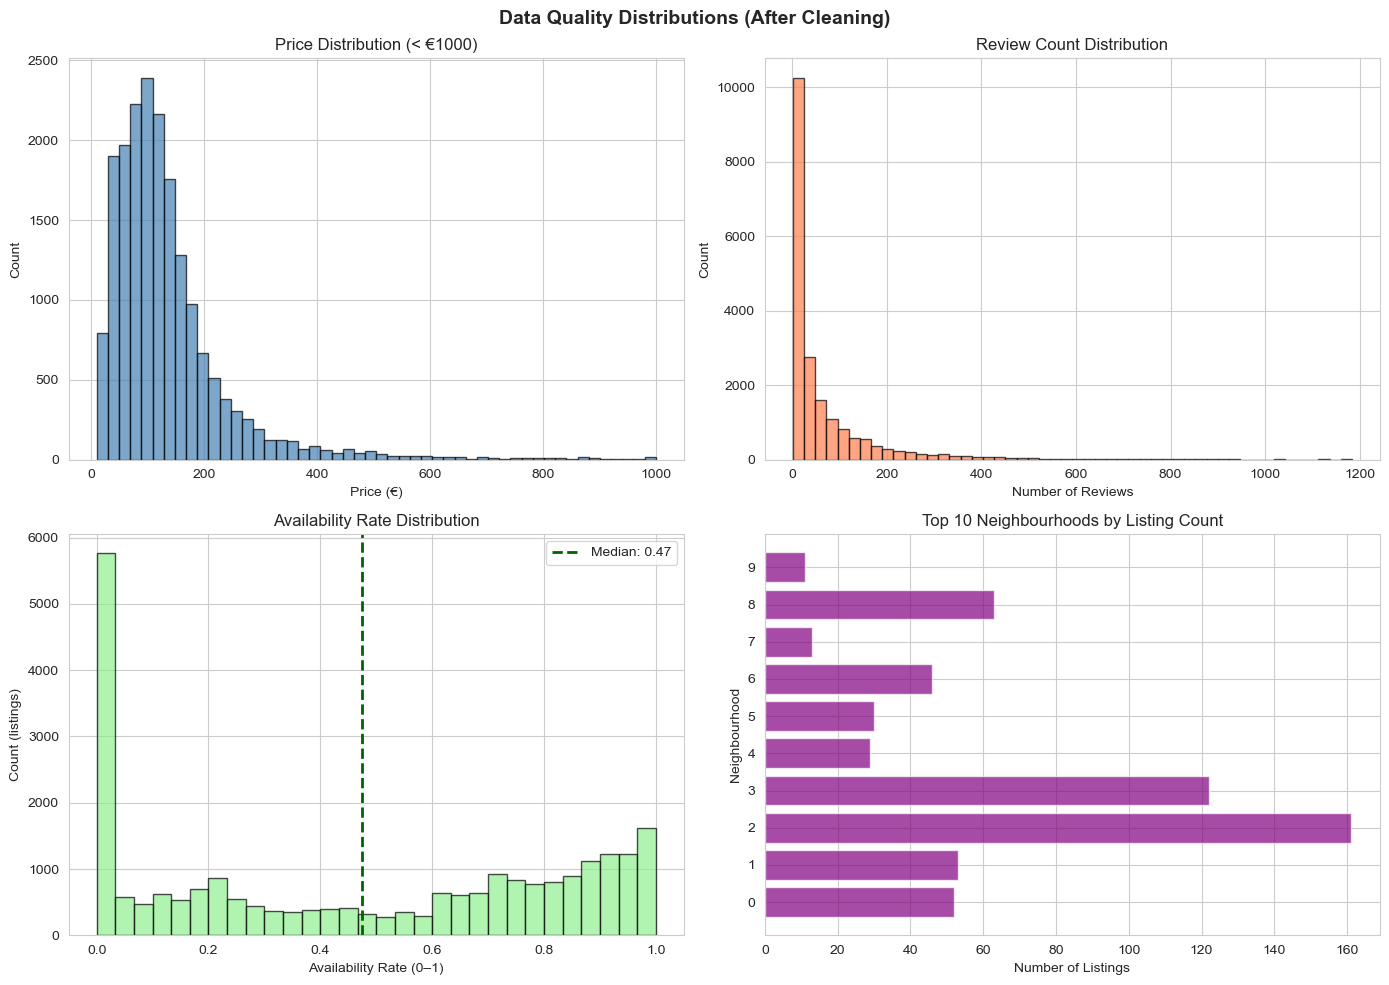

In [15]:
print("\n" + "=" * 80)
print("STEP 10: SUMMARY REPORT & VISUALIZATIONS")
print("=" * 80)

# Create summary statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Data Quality Distributions (After Cleaning)', fontsize=14, fontweight='bold')

# Price distribution
if 'price' in df_listings_clean.columns:
    prices = df_listings_clean['price'].dropna()
    axes[0, 0].hist(prices[prices < 1000], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Price Distribution (< €1000)')
    axes[0, 0].set_xlabel('Price (€)')
    axes[0, 0].set_ylabel('Count')

# Reviews distribution
if 'review_count_total' in df_listings_with_reviews.columns:
    reviews = df_listings_with_reviews['review_count_total'].dropna()
    axes[0, 1].hist(reviews, bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Review Count Distribution')
    axes[0, 1].set_xlabel('Number of Reviews')
    axes[0, 1].set_ylabel('Count')

# Availability rate - Try multiple sources
avail_rate_data = None

# Priority 1: Use availability_by_listing if it exists
try:
    if 'availability_by_listing' in dir() and 'availability_rate' in availability_by_listing.columns:
        avail_rate_data = availability_by_listing['availability_rate'].dropna()
except:
    pass

# Priority 2: Try df_listings_with_reviews if exists
if avail_rate_data is None:
    try:
        if 'availability_rate' in df_listings_with_reviews.columns:
            avail_rate_data = df_listings_with_reviews['availability_rate'].dropna()
    except:
        pass

# Priority 3: Try to calculate from df_calendar_clean
if avail_rate_data is None:
    try:
        # Find availability column
        avail_col = None
        for col in df_calendar_clean.columns:
            if 'available' in col.lower():
                avail_col = col
                break
        
        if avail_col is not None:
            # Calculate availability rate per listing
            avail_df = df_calendar_clean[[avail_col, 'listing_id']].copy()
            avail_df[avail_col] = pd.to_numeric(avail_df[avail_col], errors='coerce')
            avail_rate_data = avail_df.groupby('listing_id')[avail_col].mean().dropna()
    except:
        pass

# Plot with quality checks and fallback
if avail_rate_data is not None and len(avail_rate_data) > 0:
    # Quality check: clamp to [0, 1]
    out_of_range = ((avail_rate_data < 0) | (avail_rate_data > 1)).sum()
    if out_of_range > 0:
        print(f"⚠️  {out_of_range} availability values out of [0,1] range - clamping")
        avail_rate_data = avail_rate_data.clip(0, 1)
    
    # Plot histogram
    axes[1, 0].hist(avail_rate_data, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    
    # Add median line
    median_avail = avail_rate_data.median()
    axes[1, 0].axvline(median_avail, color='darkgreen', linestyle='--', linewidth=2, label=f'Median: {median_avail:.2f}')
    
    # Labels and formatting
    axes[1, 0].set_title('Availability Rate Distribution')
    axes[1, 0].set_xlabel('Availability Rate (0–1)')
    axes[1, 0].set_ylabel('Count (listings)')
    axes[1, 0].legend(loc='upper right')
else:
    # Fallback: show message
    axes[1, 0].text(0.5, 0.5, 'Availability Rate\nData Not Available', 
                    ha='center', va='center', fontsize=12, color='gray',
                    transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Availability Rate Distribution')
    axes[1, 0].axis('off')

# Neighbourhood listing count
n_listings = gdf_neighbourhoods_enriched['n_listings'].dropna()
axes[1, 1].barh(range(len(n_listings.tail(10))), n_listings.tail(10).values, color='purple', alpha=0.7)
axes[1, 1].set_yticks(range(len(n_listings.tail(10))))
axes[1, 1].set_ylabel('Neighbourhood')
axes[1, 1].set_xlabel('Number of Listings')
axes[1, 1].set_title('Top 10 Neighbourhoods by Listing Count')

plt.tight_layout()
plt.savefig(config.OUTPUT_FILES['calendar_clean'].parent / '01_data_quality_distributions.png', dpi=150, bbox_inches='tight')
print(f"\n✓ Saved visualization: 01_data_quality_distributions.png")

# Print summary statistics
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print(f"\n📊 Dataset Statistics:")
print(f"  Total listings: {len(df_listings_clean):,}")
print(f"  Listings with reviews: {df_listings_with_reviews[df_listings_with_reviews['review_count_total'].notna()].shape[0]:,}")
print(f"  Total reviews: {df_reviews_clean.shape[0]:,}")
print(f"  Calendar records: {df_calendar_clean.shape[0]:,}")
print(f"  Neighbourhoods: {len(gdf_neighbourhoods_clean)}")

print(f"\n💰 Price Statistics:")
if 'price' in df_listings_clean.columns:
    prices = df_listings_clean['price'].dropna()
    print(f"  Mean: €{prices.mean():.2f}")
    print(f"  Median: €{prices.median():.2f}")
    print(f"  Std Dev: €{prices.std():.2f}")
    print(f"  Range: €{prices.min():.2f} - €{prices.max():.2f}")

print(f"\n🗺️  Spatial Coverage:")
print(f"  Listings with neighbourhood: {gdf_listings_with_neigh['neighbourhood_idx'].notna().sum():,} / {len(gdf_listings_with_neigh):,} ({gdf_listings_with_neigh['neighbourhood_idx'].notna().sum()/len(gdf_listings_with_neigh)*100:.1f}%)")
print(f"  Neighbourhoods with listings: {(gdf_neighbourhoods_enriched['n_listings'] > 0).sum()}")

print(f"\n📁 Output Files Generated:")
for name, path in config.OUTPUT_FILES.items():
    if path.exists():
        size_mb = io.file_size_mb(path)
        print(f"  ✓ {path.name:50s} {size_mb:8.2f} MB")
    else:
        print(f"  ⚠️  {path.name:50s} NOT FOUND")

print("\n" + "=" * 80)
print("✅ PIPELINE COMPLETE")
print("=" * 80)

## Step 11: Spatial Visualization - Listings by Price Quantiles


STEP 11: SPATIAL VISUALIZATION - MADRID LISTINGS BY PRICE

Data validation:
  Listings with price: 18,940
  Listings with coordinates: 24,987
  Valid listings for plot: 18,940

Price quantiles:
  Q0: €10
  Q25: €70
  Q50: €110
  Q75: €163
  Q100: €10000

Price class distribution:
  Q1 (€10–61): 4,780 (25.2%)
  Q2 (€61–110): 4,747 (25.1%)
  Q3 (€110–163): 4,678 (24.7%)
  Q4 (€163+): 4,735 (25.0%)



✓ Saved spatial visualization: fig_madrid_listings_price_distribution.png
  Resolution: 300 DPI (for publication)


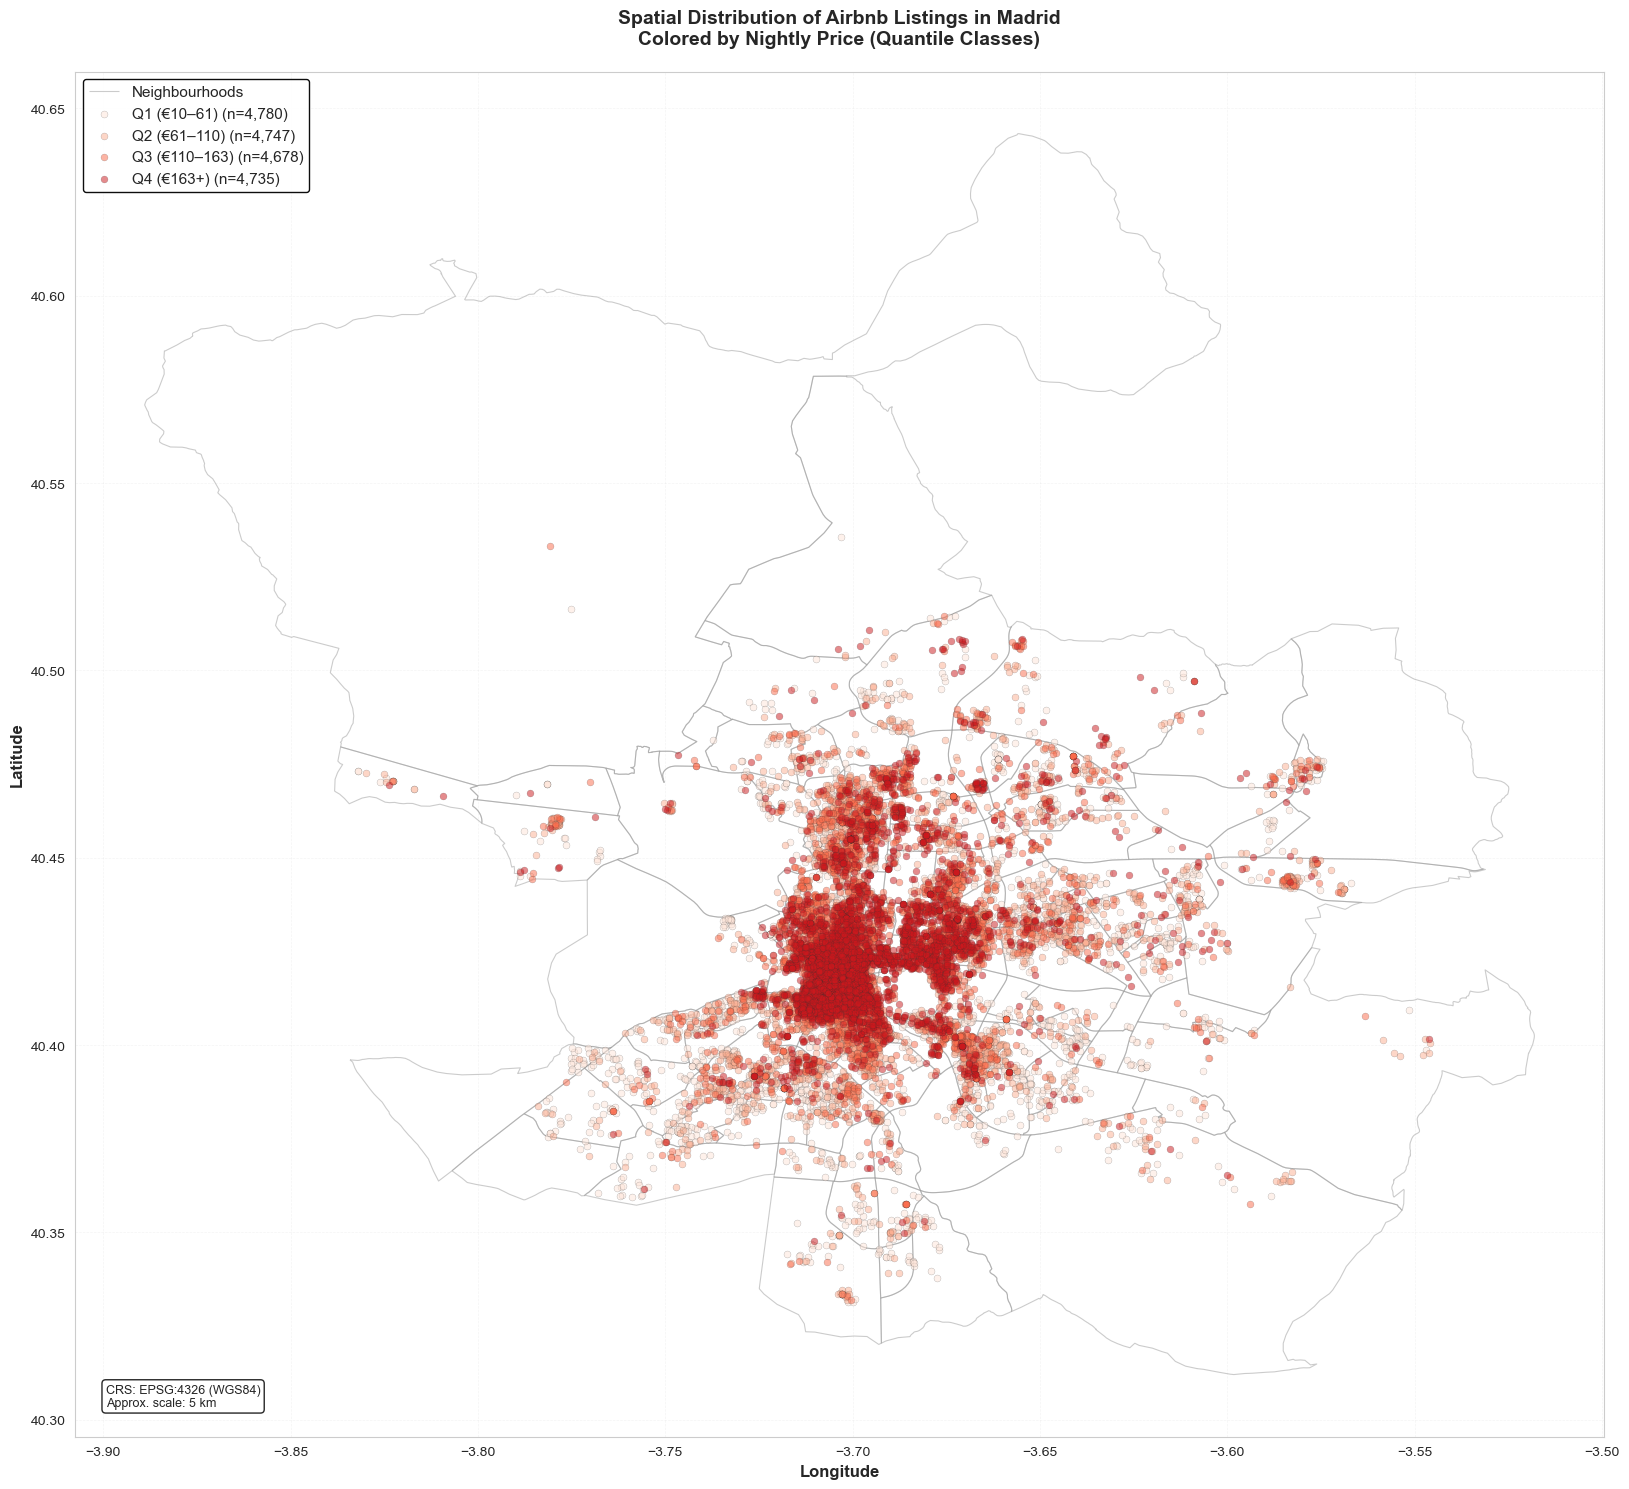

In [16]:

print("\n" + "=" * 80)
print("STEP 11: SPATIAL VISUALIZATION - MADRID LISTINGS BY PRICE")
print("=" * 80)

# Validate data
print("\nData validation:")
print(f"  Listings with price: {df_listings_clean['price'].notna().sum():,}")
print(f"  Listings with coordinates: {(df_listings_clean['latitude'].notna() & df_listings_clean['longitude'].notna()).sum():,}")

# Prepare listings for plotting: only with price and valid coords
df_plot = df_listings_clean[
    (df_listings_clean['price'].notna()) & 
    (df_listings_clean['latitude'].notna()) & 
    (df_listings_clean['longitude'].notna())
].copy()

print(f"  Valid listings for plot: {len(df_plot):,}")

# Create price quantile classes (Q1-Q4)
quantile_bins = [0.0, 0.25, 0.5, 0.75, 1.0]
quantile_values = df_plot['price'].quantile(quantile_bins)

print(f"\nPrice quantiles:")
for i, (q, val) in enumerate(zip(quantile_bins, quantile_values)):
    print(f"  Q{int(q*100)}: €{val:.0f}")

df_plot['price_class'] = pd.cut(
    df_plot['price'],
    bins=quantile_values.values,
    labels=['Q1 (€10–61)', 'Q2 (€61–110)', 'Q3 (€110–163)', 'Q4 (€163+)'],
    include_lowest=True
)

print(f"\nPrice class distribution:")
for cls, count in df_plot['price_class'].value_counts().sort_index().items():
    pct = 100 * count / len(df_plot)
    print(f"  {cls}: {count:,} ({pct:.1f}%)")

# Create figure
fig, ax = plt.subplots(figsize=(18, 15), dpi=100)

# Plot neighbourhood boundaries
gdf_neighbourhoods_clean.boundary.plot(
    ax=ax, linewidth=0.8, color='#999999', alpha=0.5, label='Neighbourhoods'
)

# Color palette (colorblind-friendly, warm)
colors_dict = {
    'Q1 (€10–61)': '#fee5d9',
    'Q2 (€61–110)': '#fcae91',
    'Q3 (€110–163)': '#fb6a4a',
    'Q4 (€163+)': '#cb181d'
}

# Plot listings by price class
for price_class in ['Q1 (€10–61)', 'Q2 (€61–110)', 'Q3 (€110–163)', 'Q4 (€163+)']:
    df_class = df_plot[df_plot['price_class'] == price_class]
    ax.scatter(
        df_class['longitude'],
        df_class['latitude'],
        c=colors_dict[price_class],
        s=25,
        alpha=0.5,
        edgecolors='#333333',
        linewidth=0.2,
        label=f"{price_class} (n={len(df_class):,})",
        zorder=10
    )

# Formatting
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('Spatial Distribution of Airbnb Listings in Madrid\nColored by Nightly Price (Quantile Classes)', 
             fontsize=14, fontweight='bold', pad=20)

ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax.legend(
    loc='upper left',
    fontsize=11,
    framealpha=0.95,
    edgecolor='black',
    fancybox=True,
    frameon=True
)

# Add scale note
ax.text(
    0.02, 0.02,
    "CRS: EPSG:4326 (WGS84)\nApprox. scale: 5 km",
    transform=ax.transAxes,
    fontsize=9,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, edgecolor='black', linewidth=1),
    verticalalignment='bottom'
)

ax.set_aspect('equal')

# Save figure
output_path = config.OUTPUT_FILES['calendar_clean'].parent.parent / "figures"
output_path.mkdir(parents=True, exist_ok=True)
fig_path = output_path / "fig_madrid_listings_price_distribution.png"

plt.tight_layout()
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
print(f"\n✓ Saved spatial visualization: {fig_path.name}")
print(f"  Resolution: 300 DPI (for publication)")

plt.show()

print("\n" + "=" * 80)



STEP 12: PUBLICATION FIGURE - OVERVIEW + INSET (PRICE QUANTILES)

[1/6] Preparing data...
  Valid listings: 18,940

  Price quantile boundaries:
    Q0: €10
    Q25: €70
    Q50: €110
    Q75: €163
    Q100: €10000

  Price class distribution:
    Q1 (Lowest): 4,780 (25.2%) | €10–€70
    Q2: 4,747 (25.1%) | €71–€110
    Q3: 4,678 (24.7%) | €111–€163
    Q4 (Highest): 4,735 (25.0%) | €164–€10000

[2/6] Identifying Centro neighbourhood for inset zoom...
  Using column 'neighbourhood' for neighbourhood names
  Available neighbourhoods (first 10):
    1. Palacio
    2. Embajadores
    3. Cortes
    4. Justicia
    5. Universidad
    6. Sol
    7. Imperial
    8. Acacias
    9. Chopera
    10. Legazpi

  ⚠️  Centro not found; using Madrid centroid
  Using hardcoded fallback inset bounds

[3/6] Creating overview + inset figure...

[4/6] Creating inset zoom panel...


  Listings in inset zoom: 13,667

[5/6] Saving figure...


  ✓ Saved: /Users/virginiadimauro/Desktop/UNITN/Secondo Anno/Geospatial Analysis/geospatial-project/data/figures/fig_madrid_overview_inset_price.png
  Resolution: 300 DPI
  Format: PNG
  Size: 4.11 MB


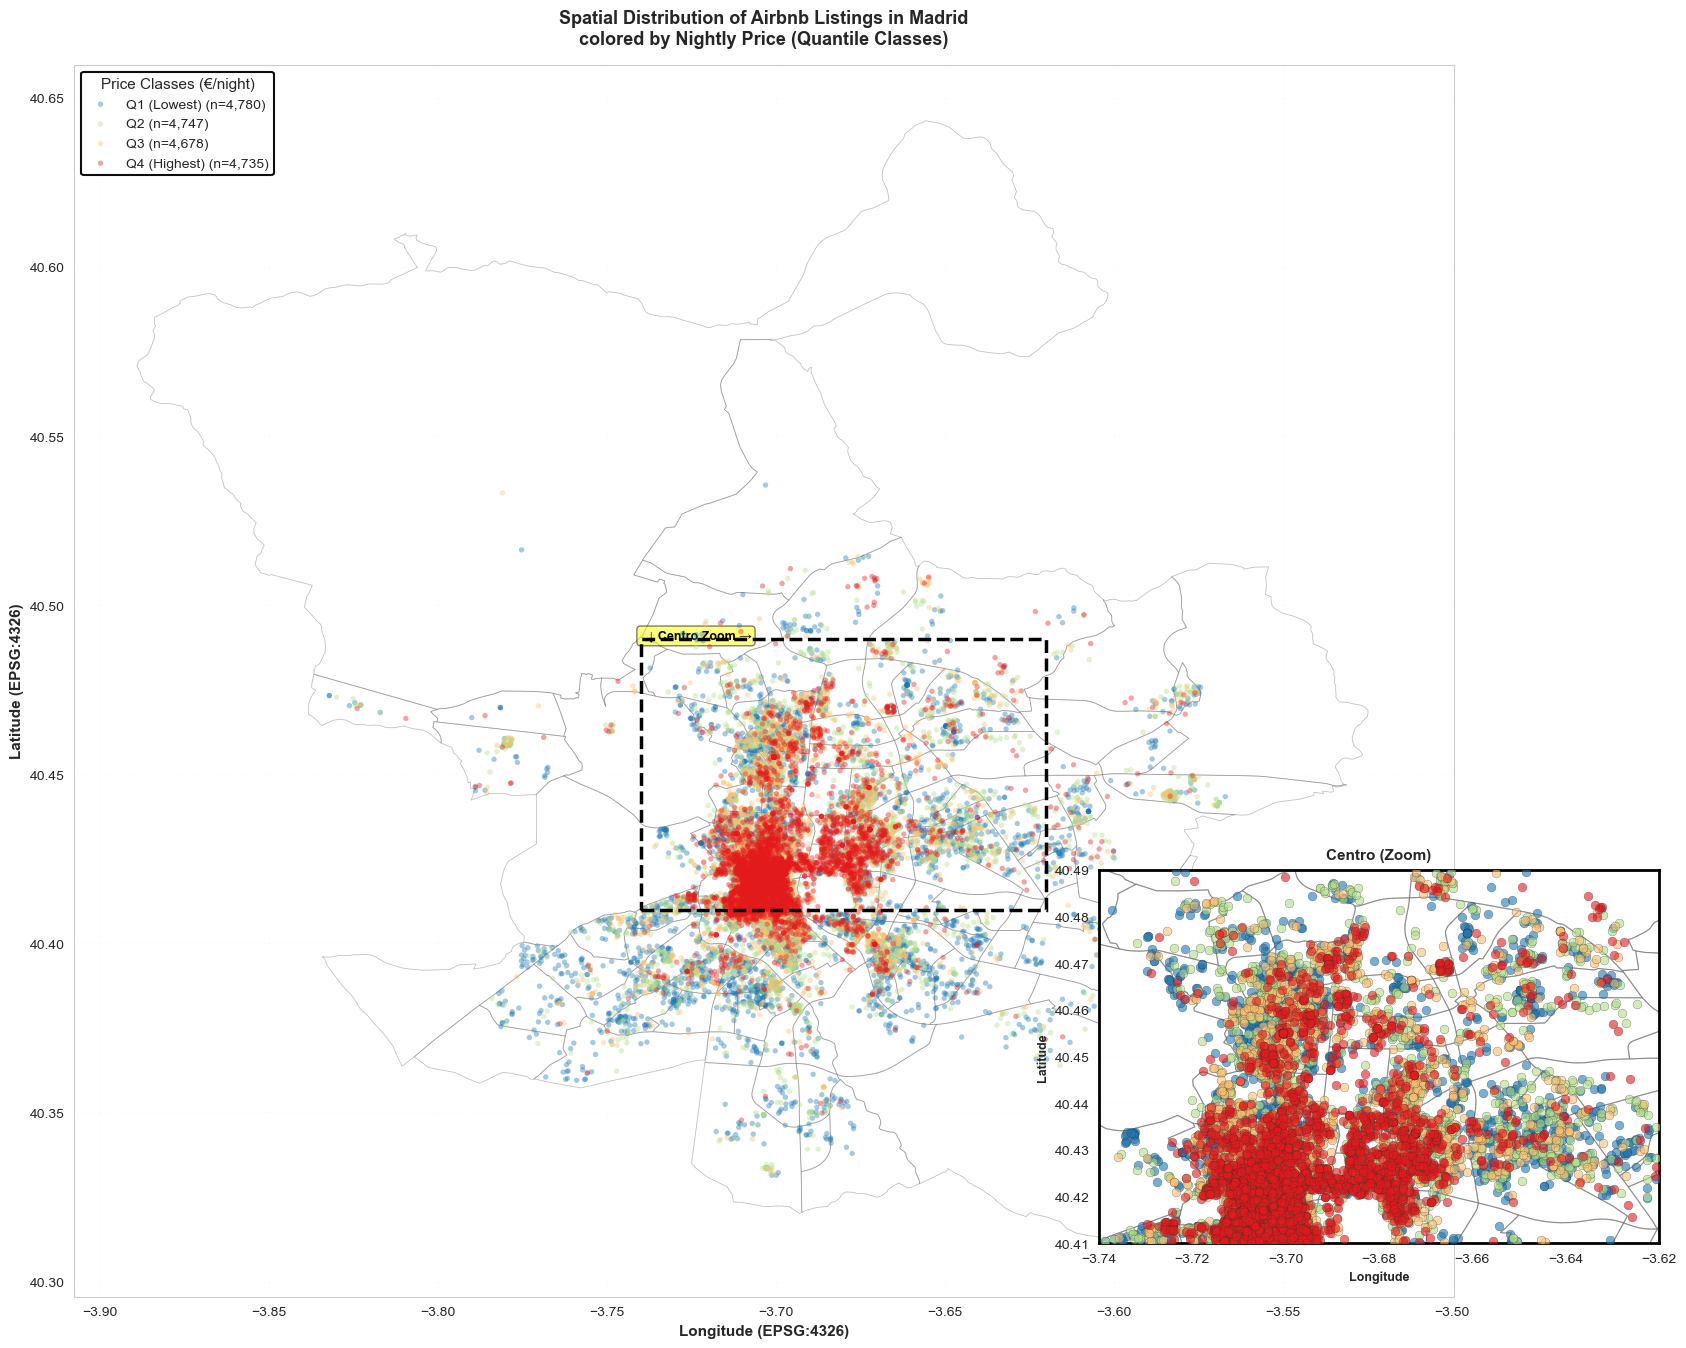


[6/6] Summary...

PUBLICATION FIGURE: Overview + Inset

Input Data:
  - Listings: 18,940 with valid price and coordinates
  - Neighbourhoods: 128 polygons (EPSG:4326)

Price Quantiles (entire dataset):
  Q1 (Lowest)    : €    10–€     70 (n=4,780,  25.2%)
  Q2             : €    71–€    110 (n=4,747,  25.1%)
  Q3             : €   111–€    163 (n=4,678,  24.7%)
  Q4 (Highest)   : €   164–€  10000 (n=4,735,  25.0%)

Colour Mapping (Exact Palette):
  Q1 (Lowest):  Blue        #1F78B4
  Q2:           Light Green #B2DF8A
  Q3:           Orange      #FDBF6F
  Q4 (Highest): Red         #E31A1C

Inset Zoom (Centro):
  Bounds (EPSG:4326): lon [-3.7400, -3.6200]
                      lat [40.4100, 40.4900]
  Buffer applied: 2 km (metric EPSG:25830)
  Listings in zoom: 13,667

Output:
  Path: /Users/virginiadimauro/Desktop/UNITN/Secondo Anno/Geospatial Analysis/geospatial-project/data/figures/fig_madrid_overview_inset_price.png
  Format: PNG, 300 DPI
  Suitable for publication in journal/thesis

In [17]:

print("\n" + "=" * 80)
print("STEP 12: PUBLICATION FIGURE - OVERVIEW + INSET (PRICE QUANTILES)")
print("=" * 80)

from matplotlib.patches import Rectangle
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches

# ============================================================================
# 1. PREPARE DATA
# ============================================================================

print("\n[1/6] Preparing data...")

# Listings: filter valid price and coordinates
df_plot = df_listings_clean[
    (df_listings_clean['price'].notna()) & 
    (df_listings_clean['latitude'].notna()) & 
    (df_listings_clean['longitude'].notna())
].copy()

print(f"  Valid listings: {len(df_plot):,}")

# Create price quantile classes (Q1-Q4)
quantile_bins = [0.0, 0.25, 0.5, 0.75, 1.0]
quantile_values = df_plot['price'].quantile(quantile_bins)

print(f"\n  Price quantile boundaries:")
for i, (q, val) in enumerate(zip(quantile_bins, quantile_values)):
    print(f"    Q{int(q*100)}: €{val:.0f}")

# Define price classes and colors (exact palette as specified)
colors_map = {
    'Q1 (Lowest)': '#1F78B4',   # Blue
    'Q2': '#B2DF8A',             # Light Green
    'Q3': '#FDBF6F',             # Orange
    'Q4 (Highest)': '#E31A1C'    # Red
}

df_plot['price_class'] = pd.cut(
    df_plot['price'],
    bins=quantile_values.values,
    labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'],
    include_lowest=True
)

df_plot['color_hex'] = df_plot['price_class'].map(colors_map)

print(f"\n  Price class distribution:")
class_counts = {}
for cls in ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']:
    count = (df_plot['price_class'] == cls).sum()
    class_counts[cls] = count
    price_range = df_plot[df_plot['price_class'] == cls]['price']
    pct = 100 * count / len(df_plot)
    print(f"    {cls}: {count:,} ({pct:.1f}%) | €{price_range.min():.0f}–€{price_range.max():.0f}")

# ============================================================================
# 2. IDENTIFY AND BUFFER CENTRO NEIGHBOURHOOD FOR INSET
# ============================================================================

print("\n[2/6] Identifying Centro neighbourhood for inset zoom...")

# Find neighbourhood name column
neigh_name_col = None
for col in gdf_neighbourhoods_clean.columns:
    if col.lower() in ['neighbourhood', 'name', 'barrio', 'neighbourhood_group']:
        if gdf_neighbourhoods_clean[col].dtype == 'object':
            neigh_name_col = col
            break

if neigh_name_col is None:
    # Fallback: use first non-geometry column
    neigh_name_col = [c for c in gdf_neighbourhoods_clean.columns if c != 'geometry'][0]

print(f"  Using column '{neigh_name_col}' for neighbourhood names")
print(f"  Available neighbourhoods (first 10):")
for i, name in enumerate(gdf_neighbourhoods_clean[neigh_name_col].head(10)):
    print(f"    {i+1}. {name}")

# Find Centro (or closest match)
centro_candidates = gdf_neighbourhoods_clean[
    gdf_neighbourhoods_clean[neigh_name_col].str.lower().str.contains('centro|center', na=False)
]

if len(centro_candidates) > 0:
    centro_neighbourhood = centro_candidates.iloc[0]
    print(f"\n  ✓ Found Centro: {centro_neighbourhood[neigh_name_col]}")
else:
    # Use centroid of Madrid as fallback
    print(f"\n  ⚠️  Centro not found; using Madrid centroid")
    centro_neighbourhood = None

# Define inset bbox (reproject to metric, apply buffer, convert back)
if centro_neighbourhood is not None:
    # Reproject neighbourhood to metric CRS
    gdf_neigh_metric = gdf_neighbourhoods_clean.to_crs(CRS_METRIC)
    centro_metric = gdf_neigh_metric[gdf_neigh_metric[neigh_name_col] == centro_neighbourhood[neigh_name_col]].iloc[0]
    
    # Get bounds and apply buffer (2000 m = 2 km)
    bounds = centro_metric.geometry.bounds  # (minx, miny, maxx, maxy)
    buffer_m = 2000
    inset_bounds_metric = (
        bounds[0] - buffer_m,
        bounds[1] - buffer_m,
        bounds[2] + buffer_m,
        bounds[3] + buffer_m
    )
    
    # Create bbox polygon and convert to EPSG:4326
    from shapely.geometry import box
    inset_box_metric = box(*inset_bounds_metric)
    inset_gdf_metric = gpd.GeoDataFrame([1], geometry=[inset_box_metric], crs=CRS_METRIC)
    inset_gdf_4326 = inset_gdf_metric.to_crs(CRS_WEB)
    inset_bounds_4326 = inset_gdf_4326.geometry.iloc[0].bounds  # (minx, miny, maxx, maxy)
    
    print(f"  Inset bounds (EPSG:4326):")
    print(f"    lon: {inset_bounds_4326[0]:.4f} to {inset_bounds_4326[2]:.4f}")
    print(f"    lat: {inset_bounds_4326[1]:.4f} to {inset_bounds_4326[3]:.4f}")
else:
    inset_bounds_4326 = (-3.74, 40.41, -3.62, 40.49)  # Hardcoded fallback centroid area
    print(f"  Using hardcoded fallback inset bounds")

# ============================================================================
# 3. CREATE FIGURE WITH OVERVIEW + INSET
# ============================================================================

print("\n[3/6] Creating overview + inset figure...")

fig = plt.figure(figsize=(20, 16), dpi=100)

# Main axis (overview)
ax_main = fig.add_subplot(111)

# Plot neighbourhood boundaries (overview)
gdf_neighbourhoods_clean.boundary.plot(
    ax=ax_main, linewidth=0.6, color='#666666', alpha=0.4, zorder=1
)

# Plot listings by price class (overview)
for price_class in ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']:
    df_class = df_plot[df_plot['price_class'] == price_class]
    color = colors_map[price_class]
    ax_main.scatter(
        df_class['longitude'],
        df_class['latitude'],
        c=color,
        s=15,
        alpha=0.4,
        edgecolors='none',
        label=f"{price_class} (n={class_counts[price_class]:,})",
        zorder=5
    )

# Add inset rectangle on main map
inset_rect = Rectangle(
    (inset_bounds_4326[0], inset_bounds_4326[1]),
    inset_bounds_4326[2] - inset_bounds_4326[0],
    inset_bounds_4326[3] - inset_bounds_4326[1],
    linewidth=2.5, edgecolor='#000000', facecolor='none', linestyle='--', zorder=10
)
ax_main.add_patch(inset_rect)

# Format main axis
ax_main.set_xlabel('Longitude (EPSG:4326)', fontsize=11, fontweight='bold')
ax_main.set_ylabel('Latitude (EPSG:4326)', fontsize=11, fontweight='bold')
ax_main.set_title(
    'Spatial Distribution of Airbnb Listings in Madrid\ncolored by Nightly Price (Quantile Classes)',
    fontsize=13, fontweight='bold', pad=15
)
ax_main.grid(True, alpha=0.15, linestyle=':', linewidth=0.5)
ax_main.set_aspect('equal')

# Legend (main)
legend_main = ax_main.legend(
    loc='upper left',
    fontsize=10,
    framealpha=0.95,
    edgecolor='black',
    fancybox=True,
    title='Price Classes (€/night)',
    title_fontsize=11
)
legend_main.get_frame().set_linewidth(1.5)

# ============================================================================
# 4. CREATE INSET AXIS (ZOOM)
# ============================================================================

print("\n[4/6] Creating inset zoom panel...")

# Create inset axis (5% of figure width/height, positioned at 12% from left, 35% from bottom)
ax_inset = fig.add_axes([0.68, 0.12, 0.28, 0.28])

# Plot neighbourhood boundaries (inset, only those within bounds)
for idx, row in gdf_neighbourhoods_clean.iterrows():
    if row.geometry.bounds[0] <= inset_bounds_4326[2] and \
       row.geometry.bounds[2] >= inset_bounds_4326[0] and \
       row.geometry.bounds[1] <= inset_bounds_4326[3] and \
       row.geometry.bounds[3] >= inset_bounds_4326[1]:
        gpd.GeoSeries([row.geometry]).boundary.plot(
            ax=ax_inset, linewidth=0.8, color='#666666', alpha=0.5, zorder=1
        )

# Plot listings (inset)
df_inset = df_plot[
    (df_plot['longitude'] >= inset_bounds_4326[0]) &
    (df_plot['longitude'] <= inset_bounds_4326[2]) &
    (df_plot['latitude'] >= inset_bounds_4326[1]) &
    (df_plot['latitude'] <= inset_bounds_4326[3])
]

print(f"  Listings in inset zoom: {len(df_inset):,}")

for price_class in ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']:
    df_class = df_inset[df_inset['price_class'] == price_class]
    color = colors_map[price_class]
    ax_inset.scatter(
        df_class['longitude'],
        df_class['latitude'],
        c=color,
        s=40,
        alpha=0.6,
        edgecolors='#333333',
        linewidth=0.3,
        zorder=5
    )

# Set inset axis limits
ax_inset.set_xlim(inset_bounds_4326[0], inset_bounds_4326[2])
ax_inset.set_ylim(inset_bounds_4326[1], inset_bounds_4326[3])
ax_inset.set_xlabel('Longitude', fontsize=9, fontweight='bold')
ax_inset.set_ylabel('Latitude', fontsize=9, fontweight='bold')
ax_inset.set_title('Centro (Zoom)', fontsize=11, fontweight='bold', pad=8)
ax_inset.grid(True, alpha=0.2, linestyle=':', linewidth=0.4)
ax_inset.set_aspect('equal')

# Add border to inset
for spine in ax_inset.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# Connect zoom rectangle to inset with lines (optional annotation)
ax_main.text(
    inset_bounds_4326[0], inset_bounds_4326[3],
    '  ↓ Centro Zoom →',
    fontsize=9, color='#000000', fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5, edgecolor='black', linewidth=1)
)

# ============================================================================
# 5. SAVE FIGURE
# ============================================================================

print("\n[5/6] Saving figure...")

output_dir = Path(config.OUTPUT_FILES['calendar_clean']).parent.parent / "figures"
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "fig_madrid_overview_inset_price.png"

plt.savefig(
    output_path,
    dpi=300,
    bbox_inches='tight',
    facecolor='white',
    edgecolor='none',
    pad_inches=0.3
)

print(f"  ✓ Saved: {output_path}")
print(f"  Resolution: 300 DPI")
print(f"  Format: PNG")
print(f"  Size: {output_path.stat().st_size / (1024**2):.2f} MB")

plt.show()

# ============================================================================
# 6. SUMMARY & DOCUMENTATION
# ============================================================================

print("\n[6/6] Summary...")

print(f"\n{'='*80}")
print("PUBLICATION FIGURE: Overview + Inset")
print(f"{'='*80}")
print(f"\nInput Data:")
print(f"  - Listings: {len(df_plot):,} with valid price and coordinates")
print(f"  - Neighbourhoods: {len(gdf_neighbourhoods_clean):,} polygons (EPSG:4326)")
print(f"\nPrice Quantiles (entire dataset):")
for cls in ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']:
    price_range = df_plot[df_plot['price_class'] == cls]['price']
    print(f"  {cls:15s}: €{price_range.min():6.0f}–€{price_range.max():7.0f} (n={class_counts[cls]:,}, {100*class_counts[cls]/len(df_plot):5.1f}%)")

print(f"\nColour Mapping (Exact Palette):")
print(f"  Q1 (Lowest):  Blue        #1F78B4")
print(f"  Q2:           Light Green #B2DF8A")
print(f"  Q3:           Orange      #FDBF6F")
print(f"  Q4 (Highest): Red         #E31A1C")

print(f"\nInset Zoom (Centro):")
print(f"  Bounds (EPSG:4326): lon [{inset_bounds_4326[0]:.4f}, {inset_bounds_4326[2]:.4f}]")
print(f"                      lat [{inset_bounds_4326[1]:.4f}, {inset_bounds_4326[3]:.4f}]")
print(f"  Buffer applied: 2 km (metric EPSG:25830)")
print(f"  Listings in zoom: {len(df_inset):,}")

print(f"\nOutput:")
print(f"  Path: {output_path}")
print(f"  Format: PNG, 300 DPI")
print(f"  Suitable for publication in journal/thesis reports")

print(f"\n{'='*80}")

